In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [7]:
df = pd.read_excel("../data/Telco_customer_churn.xlsx")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (7043, 33)

First few rows:


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Exploration already done in EDA

In [11]:
# Columns that must NOT be used for clustering
columns_to_drop = [
    "CustomerID",
    "Count",
    "Country",
    "State",
    "City",
    "Zip Code",
    "Latitude",
    "Longitude",
    "Lat Long",
    "Churn Value",
    "Churn Label",
    "Churn Reason",
    "Churn Score"
]

df_cluster = df.drop(columns=columns_to_drop)

# Convert Total Charges to numeric
df_cluster['Total Charges'] = pd.to_numeric(df_cluster['Total Charges'], errors='coerce')

# Handle missing values
print(f"\nMissing values before handling:\n{df_cluster.isnull().sum()}")
df_cluster.fillna(
    {'Total Charges': df_cluster['Total Charges'].median()},
    inplace=True
)

# Identify numerical and categorical columns
numeric = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
category = [col for col in df_cluster.columns if col not in numeric]


Missing values before handling:
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
CLTV                  0
dtype: int64


In [17]:
print(f"Numerical features ({len(numeric)}): {numeric}")
print(f"\nCategorical features ({len(category)}): {category}")

Numerical features (4): ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']

Categorical features (16): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


K-Means clustering was used to segment customers into homogeneous groups based on their characteristics and service usage.
This method is well suited for customer segmentation and is aligned with the techniques covered in the course.
Numerical variables such as tenure, monthly charges, and customer lifetime value capture customer value and maturity, while categorical variables describe service behavior and contract types.
All features were standardized and encoded to ensure meaningful distance-based clustering.

ENCODE CATEGORICAL

In [23]:
df_encoded = df_cluster.copy()

# Label encode
label_encoders = {}
for col in category:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_cluster[col].astype(str))
    label_encoders[col] = le

print("Encoded data shape:", df_encoded.shape)

df_encoded.head()

Encoded data shape: (7043, 20)


,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,3239
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,2701
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,820.50,5372
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,3046.05,5003
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,5036.30,5340


STANDARDIZE FEATURES

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print(f"Scaled data shape: {X_scaled.shape}")

Scaled data shape: (7043, 20)


FIND OPTIMAL K

In [25]:
inertia = []
silhouette_scores = []
k_range = range(2, 11)

print("Calculating different K:")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")


Calculating metrics for different K values...
K=2: Inertia=119168.20, Silhouette=0.153
K=3: Inertia=107874.09, Silhouette=0.133
K=4: Inertia=101104.56, Silhouette=0.149
K=5: Inertia=96143.10, Silhouette=0.140
K=6: Inertia=92915.52, Silhouette=0.137
K=7: Inertia=89790.41, Silhouette=0.113
K=8: Inertia=87038.89, Silhouette=0.116
K=9: Inertia=84983.80, Silhouette=0.110
K=10: Inertia=83558.24, Silhouette=0.111


lot Elbow

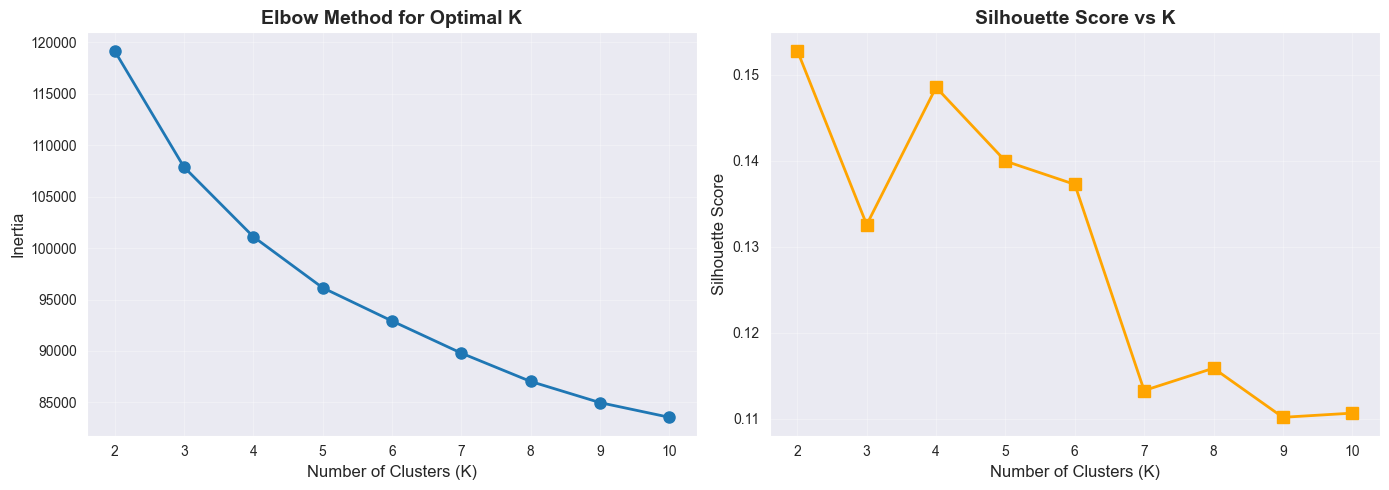

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertia, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, marker='s', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# PERFORMING K-MEANS CLUSTERING WITH K= 4 ( K = [3-5] )
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

# Add labels to dataframe
df_cluster['Cluster'] = clusters
df['Cluster'] = clusters

In [29]:
silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)

print(f"Clustering Evaluation Metrics:")
print(f"  Silhouette Score: {silhouette:.3f} (higher is better, range: -1 to 1)")
print(f"  Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
print(f"  Inertia: {kmeans_final.inertia_:.2f}")

Clustering Evaluation Metrics:
  Silhouette Score: 0.148 (higher is better, range: -1 to 1)
  Davies-Bouldin Index: 2.002 (lower is better)
  Inertia: 101104.20


In [30]:
print(f"\nCluster Distribution:")
cluster_counts = df['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")


Cluster Distribution:
  Cluster 0: 656 customers (9.3%)
  Cluster 1: 1545 customers (21.9%)
  Cluster 2: 2057 customers (29.2%)
  Cluster 3: 2785 customers (39.5%)



CLUSTER CHARACTERISTICS - NUMERICAL FEATURES



,Tenure Months,Monthly Charges,Total Charges,CLTV
Cluster,,,,
0,30.17,41.16,1379.96,4283.98
1,30.53,21.66,680.58,4371.19
2,56.58,92.40,5236.69,4957.44
3,16.03,73.82,1201.46,4032.33


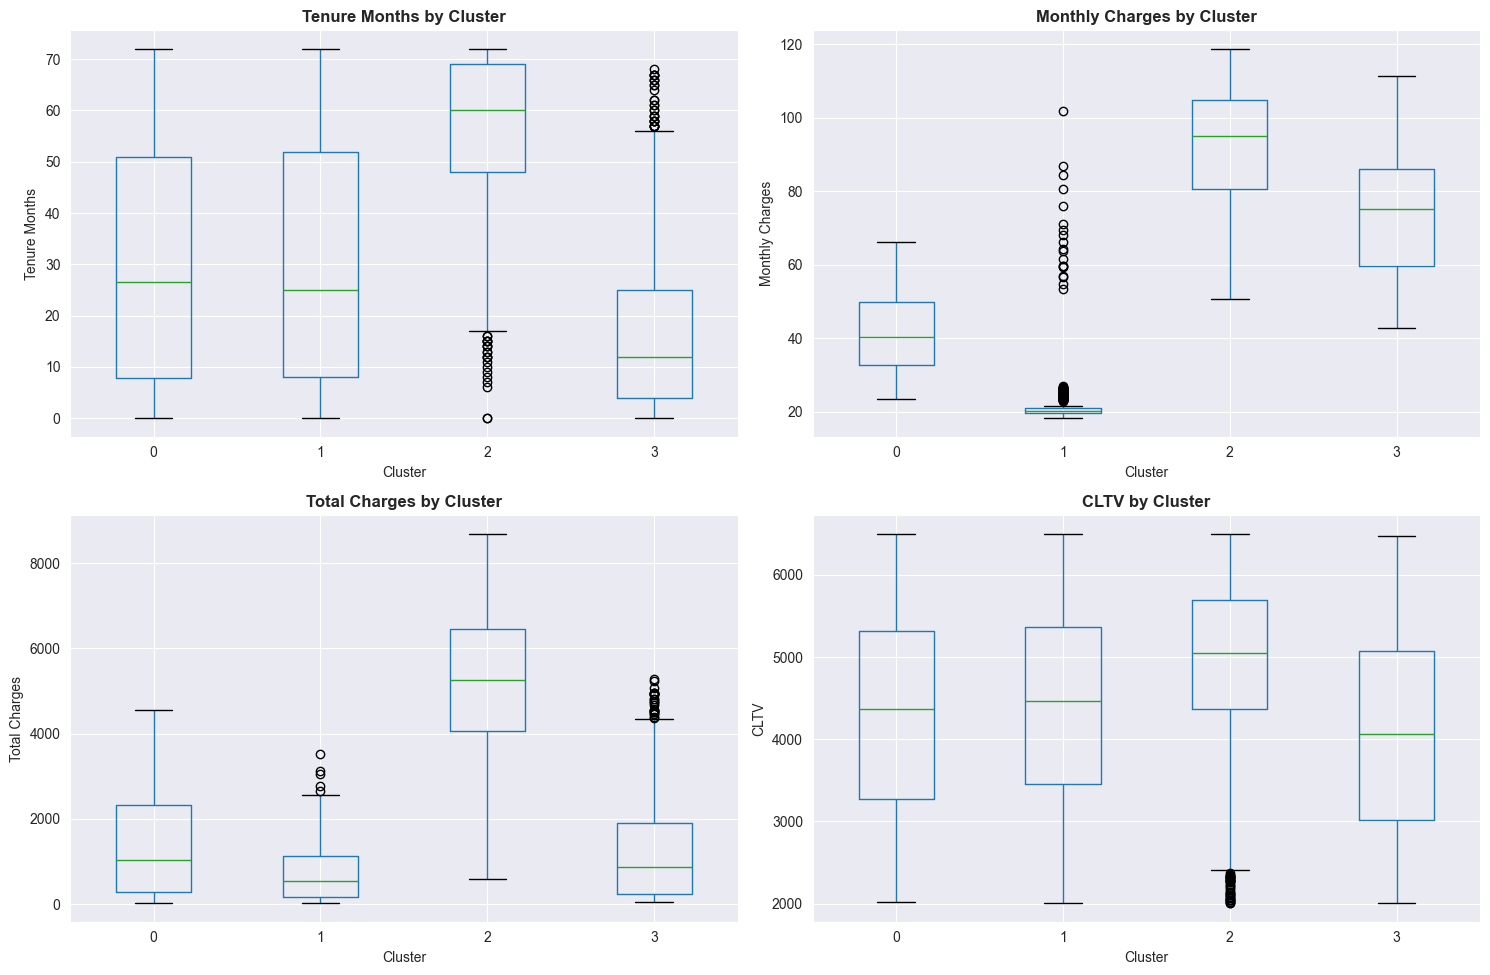

In [44]:
print(f"\n{'='*60}")
print("CLUSTER CHARACTERISTICS - NUMERICAL FEATURES")
print(f"{'='*60}\n")

# Ensure numerical columns are actually numeric
for col in numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

cluster_summary = df.groupby('Cluster')[numeric].mean()
display(cluster_summary.round(2))

# Visualize numerical features by cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(numeric):
    df.boxplot(column=feature, by='Cluster', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=0)

plt.suptitle('')
plt.tight_layout()
plt.show()

In [35]:
print("CLUSTER CHARACTERISTICS - KEY CATEGORICAL FEATURES")

# Analyze key categorical features
key_cat_features = ['Contract', 'Internet Service', 'Payment Method',
                    'Paperless Billing', 'Senior Citizen']

for feature in key_cat_features:
    print(f"\n{feature}:")
    cross_tab = pd.crosstab(df['Cluster'], df[feature], normalize='index') * 100
    display(cross_tab.round(1))


CLUSTER CHARACTERISTICS - KEY CATEGORICAL FEATURES

Contract:


Contract,Month-to-month,One year,Two year
Cluster,,,
0,57.3,22.0,20.7
1,34.0,24.1,41.9
2,22.6,34.1,43.3
3,90.1,9.1,0.8



Internet Service:


Internet Service,DSL,Fiber optic,No
Cluster,,,
0,100.0,0.0,0.0
1,1.0,0.3,98.8
2,36.4,63.6,0.0
3,36.0,64.0,0.0



Payment Method:


Payment Method,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
Cluster,,,,
0,19.4,22.3,34.1,24.2
1,21.7,21.6,8.2,48.5
2,32.7,31.4,28.2,7.7
3,14.7,14.3,51.5,19.5



Paperless Billing:


Paperless Billing,No,Yes
Cluster,,
0,43.6,56.4
1,71.1,28.9
2,31.6,68.4
3,30.0,70.0



Senior Citizen:


Senior Citizen,No,Yes
Cluster,,
0,84.8,15.2
1,96.6,3.4
2,80.3,19.7
3,79.0,21.0


In [39]:
print("CHURN RATE BY CLUSTER")

churn_by_cluster = df.groupby('Cluster')['Churn Label'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
)
display(churn_by_cluster.round(2))

CHURN RATE BY CLUSTER


Cluster
0    25.91
1     7.31
2    14.83
3    46.00
Name: Churn Label, dtype: float64


Performing PCA for visualization...
Explained variance by PC1: 21.73%
Explained variance by PC2: 11.57%
Total explained variance: 33.31%


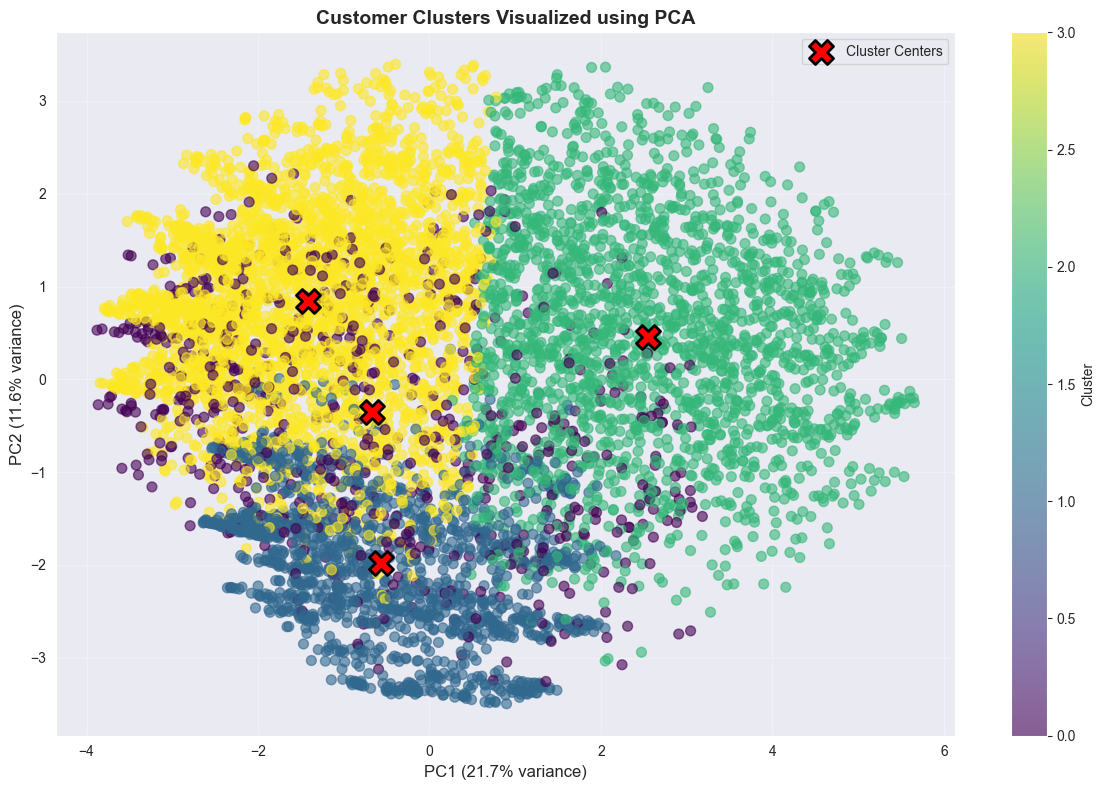

In [40]:
print("\nPerforming PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_var[0]:.2%}")
print(f"Explained variance by PC2: {explained_var[1]:.2%}")
print(f"Total explained variance: {explained_var.sum():.2%}")

# Plot PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters,
                     cmap='viridis', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance)', fontsize=12)
plt.title('Customer Clusters Visualized using PCA', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidths=2,
           label='Cluster Centers')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
print(f"\n{'='*60}")
print("CLUSTER PROFILES SUMMARY")
print(f"{'='*60}\n")

profile_data = []

for cluster_id in range(optimal_k):
    cluster_data = df[df['Cluster'] == cluster_id].copy()

    # Convert to numeric
    cluster_data['Tenure Months'] = pd.to_numeric(cluster_data['Tenure Months'], errors='coerce')
    cluster_data['Monthly Charges'] = pd.to_numeric(cluster_data['Monthly Charges'], errors='coerce')
    cluster_data['Total Charges'] = pd.to_numeric(cluster_data['Total Charges'], errors='coerce')
    cluster_data['CLTV'] = pd.to_numeric(cluster_data['CLTV'], errors='coerce')

    size = len(cluster_data)
    size_pct = (size / len(df)) * 100
    churn_rate = (cluster_data['Churn Label'] == 'Yes').sum() / size * 100
    avg_tenure = cluster_data['Tenure Months'].mean()
    avg_monthly = cluster_data['Monthly Charges'].mean()
    avg_total = cluster_data['Total Charges'].mean()
    avg_cltv = cluster_data['CLTV'].mean()

    profile_data.append({
        'Cluster': cluster_id,
        'Size': size,
        'Size_Pct': size_pct,
        'Churn_Rate': churn_rate,
        'Avg_Tenure': avg_tenure,
        'Avg_Monthly': avg_monthly,
        'Avg_Total': avg_total,
        'Avg_CLTV': avg_cltv,
        'Contract': cluster_data['Contract'].mode()[0],
        'Internet': cluster_data['Internet Service'].mode()[0],
        'Payment': cluster_data['Payment Method'].mode()[0]
    })

profile_df = pd.DataFrame(profile_data)
display(profile_df)


CLUSTER PROFILES SUMMARY



,Cluster,Size,Size_Pct,Churn_Rate,Avg_Tenure,Avg_Monthly,Avg_Total,Avg_CLTV,Contract,Internet,Payment
0,0,656,9.314213,25.914634,30.170732,41.164710,1379.964602,4283.984756,Month-to-month,DSL,Electronic check
1,1,1545,21.936675,7.313916,30.532039,21.658058,680.583301,4371.193528,Two year,No,Mailed check
2,2,2057,29.206304,14.827419,56.580457,92.397642,5236.691898,4957.443364,Two year,Fiber optic,Bank transfer (automatic)
3,3,2785,39.542808,45.996409,16.028725,73.820072,1201.455568,4032.328187,Month-to-month,Fiber optic,Electronic check


In [54]:
print(profile_df.columns)

Index(['Cluster', 'Size', 'Size %', 'Churn Rate %', 'Avg Tenure (months)',
       'Avg Monthly Charges', 'Avg Total Charges', 'Avg CLTV',
       'Most Common Contract', 'Most Common Internet', 'Most Common Payment'],
      dtype='object')


In [71]:
def assign_segment_name(row):
    churn = row['Churn_Rate']
    tenure = row['Avg_Tenure']
    monthly = row['Avg_Monthly']
    cltv = row['Avg_CLTV']
    contract = row['Contract']

    # High value, low churn, long tenure
    if monthly > 70:
        if churn > 35:
            return "High-Value At-Risk"
        else:
            return "High-Value Loyal"
    # Low revenue customers
    elif monthly < 30:
        if churn < 10:
            return "Low-Cost Loyal"
        else:
            return "Low-Cost At-Risk"
    # Medium revenue customers
    else:
        if churn > 20:
            return "Mid-Value At-Risk"
        else:
            return "Mid-Value Stable"

profile_df['Segment Name'] = profile_df.apply(assign_segment_name, axis=1)

# Format display
display_data = []
for _, row in profile_df.iterrows():
    display_data.append({
        'Cluster': row['Cluster'],
        'Segment Name': row['Segment Name'],
        'Size': row['Size'],
        'Size %': f"{row['Size_Pct']:.1f}%",
        'Churn Rate %': f"{row['Churn_Rate']:.1f}%",
        'Avg Tenure': f"{row['Avg_Tenure']:.1f}",
        'Avg Monthly': f"${row['Avg_Monthly']:.2f}",
        'Avg Total': f"${row['Avg_Total']:.2f}",
        'Avg CLTV': f"{row['Avg_CLTV']:.0f}",
        'Contract': row['Contract'],
        'Internet': row['Internet'],
        'Payment': row['Payment']
    })

profile_display = pd.DataFrame(display_data)
display(profile_display)

,Cluster,Segment Name,Size,Size %,Churn Rate %,Avg Tenure,Avg Monthly,Avg Total,Avg CLTV,Contract,Internet,Payment
0,0,Mid-Value At-Risk,656,9.3%,25.9%,30.2,$41.16,$1379.96,4284,Month-to-month,DSL,Electronic check
1,1,Low-Cost Loyal,1545,21.9%,7.3%,30.5,$21.66,$680.58,4371,Two year,No,Mailed check
2,2,High-Value Loyal,2057,29.2%,14.8%,56.6,$92.40,$5236.69,4957,Two year,Fiber optic,Bank transfer (automatic)
3,3,High-Value At-Risk,2785,39.5%,46.0%,16.0,$73.82,$1201.46,4032,Month-to-month,Fiber optic,Electronic check
